## Validação dos pseudo-neagtivos com XGBoost

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv('dataset_final_para_modelo_1_100.csv', decimal=',')
df

,latitude,longitude,data,dia_semana,mes,is_weekend,hora,Sinistro,Chuva,tipo_via_num,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel
0,-22.323152,-49.066030,2022-10-24,0,10,0,23,0,0,0.0,0,0,0,0,0,0,1
1,-22.330302,-49.106223,2023-03-02,3,3,0,12,0,0,0.0,0,0,0,0,0,0,1
2,-22.335932,-49.067196,2025-01-08,2,1,0,17,0,0,0.0,0,0,0,0,0,0,1
3,-22.327175,-49.116669,2024-01-23,1,1,0,19,0,0,0.0,0,0,0,0,0,0,1
4,-22.330951,-49.088352,2022-09-19,0,9,0,20,0,0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827084,-22.309319,-49.073527,2025-01-16,3,1,0,15,0,0,0.0,0,0,1,0,0,0,0
827085,-22.325896,-49.079704,2024-05-17,4,5,0,9,0,0,0.0,0,0,0,0,0,0,1
827086,-22.351893,-49.032062,2024-02-01,3,2,0,13,0,0,0.0,0,0,0,0,0,0,1
827087,-22.291783,-49.071040,2022-07-10,6,7,1,9,0,0,0.0,0,0,0,0,0,0,1


### Separação de Features (X) e Alvo (y)

In [3]:
X = df.drop(columns=['Sinistro', 'data']) 
 
y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (578962, 15)
Tamanho do conjunto de teste: (248127, 15)


### Treinar o modelo

#### GridSearchCV + Modelo Final

In [4]:
param_grid = {
    'scale_pos_weight': [75, 100, 125],
    'max_depth': [3, 5, 7, 8, 10, 20],
    'learning_rate': [0.01, 0.1, 0.05, 0.5],
    'class_pos_weight': [75, 100, 125, 150],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamama': [0, 1, 5],
    'reg_lambda': [1, 5, 10],
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Otimizar para F1-Score é ótimo no seu caso
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 5. EXECUTE O FIT COM EARLY STOPPING
print("Iniciando o GridSearchCV com Early Stopping...")
grid_search.fit(
    X_train_sub, 
    y_train_sub,
    # Aqui está a mágica:
    early_stopping_rounds=50,
    eval_set=[(X_val, y_val)],
    verbose=False # Para não poluir o output do GridSearchCV
)

print("GridSearchCV concluído.")
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)
print("\nMelhor F1-Score (validação cruzada):")
print(grid_search.best_score_)

NameError: name 'xgb_model' is not defined

In [5]:
# --- PASSO 1: GridSearchCV para encontrar a "Arquitetura" ---
print("="*30)
print("INICIANDO PASSO 1: GridSearchCV (para achar a arquitetura)...")
print("="*30)

# 1. Modelo Base para a BUSCA
#    Vamos fixar n_estimators para que a busca de 'learning_rate' funcione.
xgb_search_model = xgb.XGBClassifier(
    random_state=8,
    eval_metric='logloss',
    n_estimators=1000, # FIXO: um valor "bom o suficiente" para a busca
    use_label_encoder=False
)

# 2. Grid de Parâmetros (SEM n_estimators)
param_grid_step1 = {
    'learning_rate': [0.01, 0.05],
    'scale_pos_weight': [75, 100, 125],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'gamma': [0, 1]
}

# 3. Configurar a Busca
grid_search = GridSearchCV(
    estimator=xgb_search_model,
    param_grid=param_grid_step1,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 4. Executar a Busca (no X_train completo)
grid_search.fit(X_train, y_train)

print("\n--- PASSO 1 Concluído ---")
print("Melhores parâmetros de arquitetura encontrados:")
best_params_from_search = grid_search.best_params_
print(best_params_from_search)
print(f"Melhor F1-Score (CV): {grid_search.best_score_:.4f}")


# --- PASSO 2: Treino Final com Early Stopping (para achar n_estimators) ---
print("\n" + "="*30)
print("INICIANDO PASSO 2: Treino final com Early Stopping...")
print("="*30)

# 1. Crie o modelo final com os melhores parâmetros
#    E um n_estimators MUITO ALTO
final_model_to_train = xgb.XGBClassifier(
    random_state=8,
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=2000, # Defina um número máximo bem alto
    **best_params_from_search # Aplica os params (lr, max_depth, etc.)
)

# 2. Treine o modelo final com early stopping
#    Usamos X_test como o conjunto de validação para a parada
final_model_to_train.fit(
    X_train, y_train,
    early_stopping_rounds=50,
    eval_set=[(X_test, y_test)], # Validando contra o set de teste
    verbose=False
)

print("--- PASSO 2 Concluído ---")

# 3. O modelo final está pronto
modelo_final_otimizado = final_model_to_train

# 4. Verifique o resultado
n_arvores_ideal = modelo_final_otimizado.best_ntree_limit
print(f"Número ideal de árvores (n_estimators) encontrado: {n_arvores_ideal}")
print("Este é o seu modelo final e mais robusto.")

joblib.dump(modelo_final_otimizado, 'src/model/modelo_risco_viario.pkl')

INICIANDO PASSO 1: GridSearchCV (para achar a arquitetura)...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\pirsp\Documents\TCC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- PASSO 1 Concluído ---
Melhores parâmetros de arquitetura encontrados:
{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 7, 'scale_pos_weight': 75, 'subsample': 0.8}
Melhor F1-Score (CV): 0.7669

INICIANDO PASSO 2: Treino final com Early Stopping...


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# --- PASSO 2: Treino Final com Early Stopping (para achar n_estimators) ---
print("\n" + "="*30)
print("INICIANDO PASSO 2: Treino final com Early Stopping...")
print("="*30)

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=8, stratify=y_train
)

# 1. Crie o modelo final com os melhores parâmetros
#    E um n_estimators MUITO ALTO
final_model_to_train = xgb.XGBClassifier(
    random_state=8,
    eval_metric='logloss',
    early_stopping_rounds=50,
    n_estimators=2000,
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.5,
    max_depth=7,
    scale_pos_weight=75,
    subsample=0.8
)

# 2. Treine o modelo final com early stopping
#    Usamos X_test como o conjunto de validação para a parada
final_model_to_train.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)], # O .fit() ainda precisa saber qual set usar
    verbose=False
)

print("--- PASSO 2 Concluído ---")

# 3. O modelo final está pronto
modelo_final_otimizado = final_model_to_train

# 4. Verifique o resultado
n_arvores_ideal = modelo_final_otimizado.best_iteration
print(f"Número ideal de árvores (n_estimators) encontrado: {n_arvores_ideal}")
print("Este é o seu modelo final e mais robusto.")




INICIANDO PASSO 2: Treino final com Early Stopping...
--- PASSO 2 Concluído ---
Número ideal de árvores (n_estimators) encontrado: 292
Este é o seu modelo final e mais robusto.


In [18]:
# --- PASSO 3: Treino Final Robusto (Obrigatório) ---
print("\n" + "="*30)
print("INICIANDO PASSO 3: Treinando o modelo final em 100% dos dados.")
print("="*30)

# 1. Crie o modelo 100% final
#    (Sem 'early_stopping_rounds', pois já temos o n_estimators ideal)
modelo_final_otimizado = xgb.XGBClassifier(
    random_state=8,
    eval_metric='logloss',
    n_estimators=292, # Use o número ótimo que acabamos de encontrar
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.5,
    max_depth=7,
    scale_pos_weight=75,
    subsample=0.8
)

# 2. Treine no X_train COMPLETO
#    (Sem eval_set, pois estamos treinando para produção)
modelo_final_otimizado.fit(X_train, y_train)

print("Modelo FINAL treinado com 100% dos dados de treino.")
print("Este é o seu modelo otimizado e robusto.")

# Agora, use 'modelo_final_otimizado' para as próximas etapas
# (Busca de Limiar, Matriz de Confusão, SHAP, etc.)
joblib.dump(modelo_final_otimizado, 'src/model/modelo_risco_viario_final.pkl')


INICIANDO PASSO 3: Treinando o modelo final em 100% dos dados.
Modelo FINAL treinado com 100% dos dados de treino.
Este é o seu modelo otimizado e robusto.


['src/model/modelo_risco_viario_final.pkl']

### Proucurar o limiar ideial

In [19]:
# Calcule as probabilidades com este modelo superior
y_prob_best = modelo_final_otimizado.predict_proba(X_test)[:, 1]

# Agora, vamos encontrar o melhor balanço para o RECALL
print("--- Testando Diferentes Limiares ---")

for limiar in [0.6, 0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_ajustado = (y_prob_best >= limiar).astype(int)
    
    # Usamos zero_division=0 para evitar avisos se uma métrica for zero
    report = classification_report(y_test, y_pred_ajustado, zero_division=0, output_dict=True)
    
    # Extrai as métricas para a classe 1 (Acidente)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    
    print(f"Limiar: {limiar:.2f} -> Precision={precision:.2f} | Recall={recall:.2f} | F1-Score={f1:.2f}")


--- Testando Diferentes Limiares ---
Limiar: 0.60 -> Precision=0.84 | Recall=0.82 | F1-Score=0.83
Limiar: 0.50 -> Precision=0.80 | Recall=0.82 | F1-Score=0.81
Limiar: 0.45 -> Precision=0.78 | Recall=0.82 | F1-Score=0.80
Limiar: 0.40 -> Precision=0.76 | Recall=0.82 | F1-Score=0.79
Limiar: 0.35 -> Precision=0.73 | Recall=0.82 | F1-Score=0.77
Limiar: 0.30 -> Precision=0.69 | Recall=0.82 | F1-Score=0.75


### Fazer previsões e avaliar as métricas


--- Matriz de Confusão ---


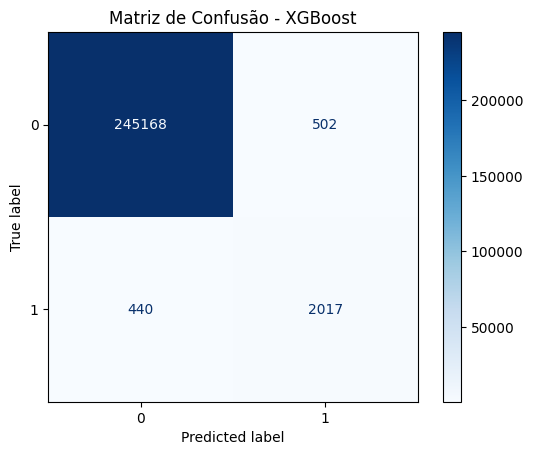

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    245670
           1       0.80      0.82      0.81      2457

    accuracy                           1.00    248127
   macro avg       0.90      0.91      0.90    248127
weighted avg       1.00      1.00      1.00    248127

--- AUC (XGBoost) ---
0.9536


In [20]:
LIMIAR_ESCOLHIDO = 0.5

y_prob_xgb = modelo_final_otimizado.predict_proba(X_test)[:, 1]
# Limiar alterado
y_pred_final = (y_prob_xgb >= LIMIAR_ESCOLHIDO).astype(int)

print("\n--- Matriz de Confusão ---")
cf_matrix = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - XGBoost")
plt.show()
print(classification_report(y_test, y_pred_final))


auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"--- AUC (XGBoost) ---")
print(f"{auc_xgb:.4f}")

#### Erro na matrix de confusão: 17,77%
#### Acerto na matriz de confusao: 82,23%

### SHAP (Shapley Additive exPlanations)

In [ ]:
#explainer_xgb = shap.Explainer(xgb_model.predict_proba, X_train)

#shap_values_obj_xgb = explainer_xgb(X_test)

# Gráfico de Resumo Detalhado (Beeswarm) para a classe 1
#shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, max_display=15, show=True)

# Gráfico de Barras (Importância Global) para a classe 1
#shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)


NameError: name 'shap' is not defined

### Salvar modelo

In [ ]:
joblib.dump(xgb_model, 'src/model/modelo_risco_viario.pkl')
print("Melhor modelo XGBoost salvo com sucesso em 'modelo_risco_viario.pkl'")


Melhor modelo XGBoost salvo com sucesso em 'modelo_risco_viario.pkl'


### Testando o modelo

In [ ]:
import requests
import json

# --- 1. CONFIGURAÇÃO ---

# O endereço exato onde o seu servidor FastAPI (uvicorn) está rodando
# (Baseado no seu código AlertasBauru.vue)
API_URL = "http://localhost:8000/calcular_risco"

# O payload exato que você quer testar, com base na sua solicitação
# (Corresponde ao schema 'InputFeatures' do server.py)
payload = {
    "latitude": -22.335372,
    "longitude": -49.117373,
    "tp_veiculo_selecionado": "tp_veiculo_automovel"
}

# Os mesmos limiares que você definiu no seu server.py para validar
# (Baseado no seu código server.py)
LIMIAR_ALTO = 0.45
LIMIAR_MEDIO = 0.2

# --- 2. EXECUÇÃO DO TESTE ---

print("--- Iniciando Script de Validação da API ---")
print(f"Enviando dados para: {API_URL}")
print("Payload de envio:")
print(json.dumps(payload, indent=2))
print("---------------------------------------------")

try:
    # Envia a requisição POST para a API
    response = requests.post(API_URL, json=payload, timeout=10)

    # Verifica se a API retornou um erro (ex: 500 Internal Server Error)
    response.raise_for_status()

    # Se a requisição foi bem-sucedida (ex: 200 OK)
    data = response.json()
    
    print("\n--- RESPOSTA RECEBIDA DA API ---")
    print(json.dumps(data, indent=2))

    # --- 3. ANÁLISE DOS RESULTADOS ---
    
    risco = data.get('risco_estimado', -1)
    interpretacao_api = data.get('interpretacao', 'ERRO')

    if risco == -1:
        print("\n[ANÁLISE]: A API retornou um erro no JSON.")
    else:
        # Recalcula a interpretação aqui no script para validar
        if risco >= LIMIAR_ALTO:
            interpretacao_script = "ALTO"
        elif risco >= LIMIAR_MEDIO:
            interpretacao_script = "MÉDIO"
        else:
            interpretacao_script = "BAIXO"

        print("\n--- VALIDAÇÃO DA LÓGICA ---")
        print(f"Risco (Probabilidade) recebido: {risco:.4f}")
        print(f"Interpretação recebida da API: {interpretacao_api}")
        print(f"Interpretação calculada localmente: {interpretacao_script}")

        if interpretacao_api == interpretacao_script:
            print("\n[RESULTADO]: VÁLIDO! A interpretação da API está correta.")
        else:
            print("\n[RESULTADO]: INVÁLIDO! A interpretação da API não corresponde ao risco.")

except requests.exceptions.HTTPError as errh:
    print(f"\n--- ERRO HTTP ---")
    print(f"A API retornou um código de erro (provavelmente 500 - Internal Server Error).")
    print(f"Status Code: {errh.response.status_code}")
    print("Resposta do servidor:")
    print(errh.response.text)
except requests.exceptions.ConnectionError as errc:
    print(f"\n--- ERRO DE CONEXÃO ---")
    print(f"Não foi possível conectar à API em {API_URL}.")
    print("Verifique se o servidor FastAPI (uvicorn) está rodando.")
except requests.exceptions.RequestException as err:
    print(f"\n--- ERRO NA REQUISIÇÃO ---")
    print(f"Ocorreu um erro: {err}")

--- Iniciando Script de Validação da API ---
Enviando dados para: http://localhost:8000/calcular_risco
Payload de envio:
{
  "latitude": -22.335372,
  "longitude": -49.117373,
  "tp_veiculo_selecionado": "tp_veiculo_automovel"
}
---------------------------------------------

--- RESPOSTA RECEBIDA DA API ---
{
  "risco_estimado": 0.98540860414505,
  "interpretacao": "ALTO",
  "timestamp": "2025-11-07T22:58:42.679235"
}

--- VALIDAÇÃO DA LÓGICA ---
Risco (Probabilidade) recebido: 0.9854
Interpretação recebida da API: ALTO
Interpretação calculada localmente: ALTO

[RESULTADO]: VÁLIDO! A interpretação da API está correta.
